## Overview

**Principal Component Analysis** is a technique used to extract one or more dimensions that capture as much of the variation of data as possible.

### Intuition

Following along with [this YouTube video](https://www.youtube.com/watch?v=_UVHneBUBW0), say we have some data points that look like the following.

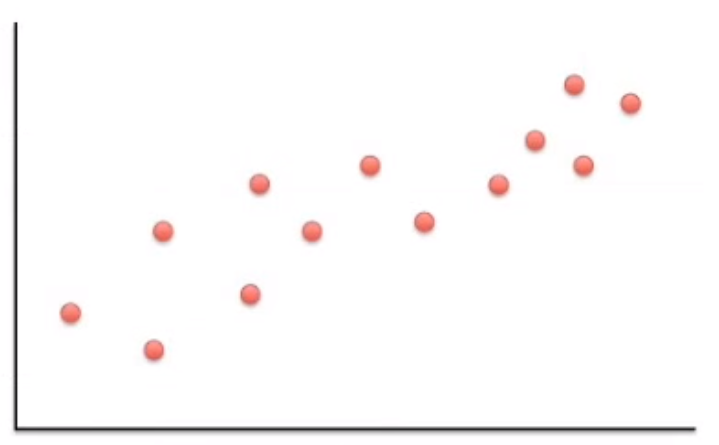

In [1]:
from IPython.display import Image

Image('images/pca_yt_1.png')

Most of the variation can be explained, not by `x` or `y` alone, but a combination of the two.

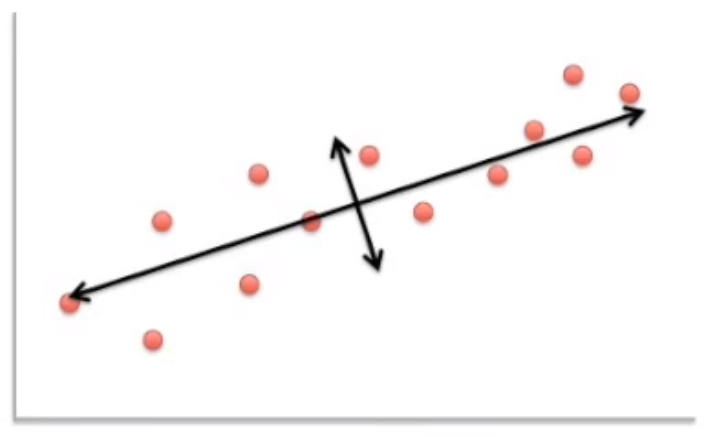

In [2]:
Image('images/pca_yt_2.png')

Indeed, if you rotate the image relative to this axis, the data looks much more organized, with the most variance explained by our "new `x` axis", and the second-most variance explained by our "new `y` axis."

These new axes are our **Principal Components**.

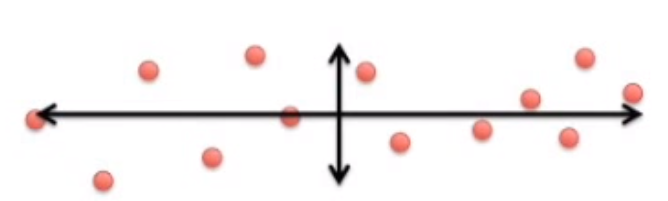

In [3]:
Image('images/pca_yt_3.png')

If you consider that this data actually represents individual Cells represented by a number of Genes, you can map each Gene's value to how much it influenced a Principal Component. High values get plotted further right. Low values get plotted further left.

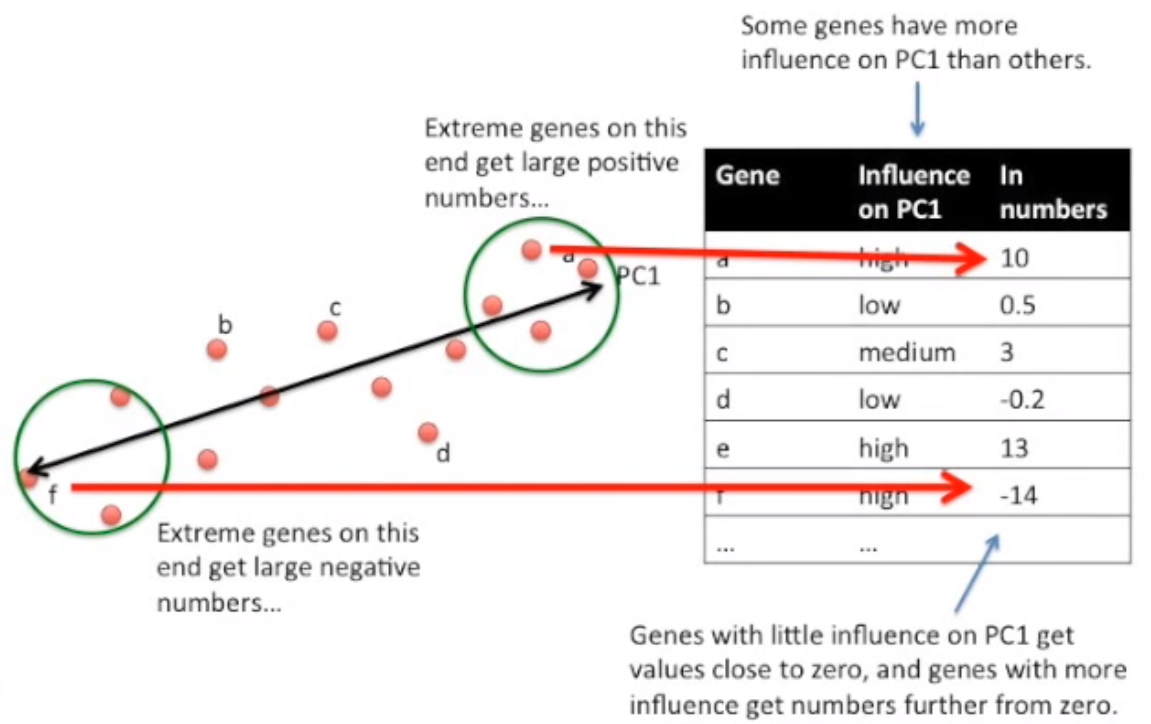

In [4]:
Image('images/pca_yt_4.png')

So if we sequenced then reduced three different cells, and Cell 1 had similar gene values to Cell 1, we might be able to represent it across two Principal Components like so.

Note, that *the first Principal Component captures the most amount of variance within the data.* Followed by the second, then third, etc.

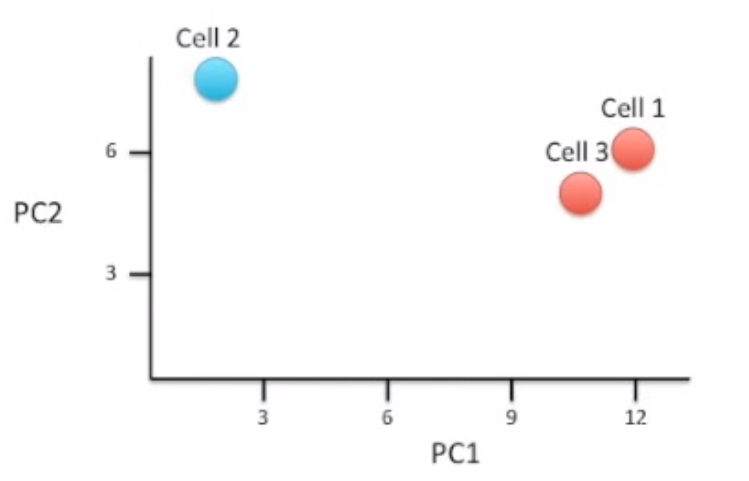

In [5]:
Image('images/pca_yt_5.png')

### Analysis and PCA

For analytical purposes, PCA affords a few interesting benefits.

First, like above, similar Cells wind up clustering close to one another.

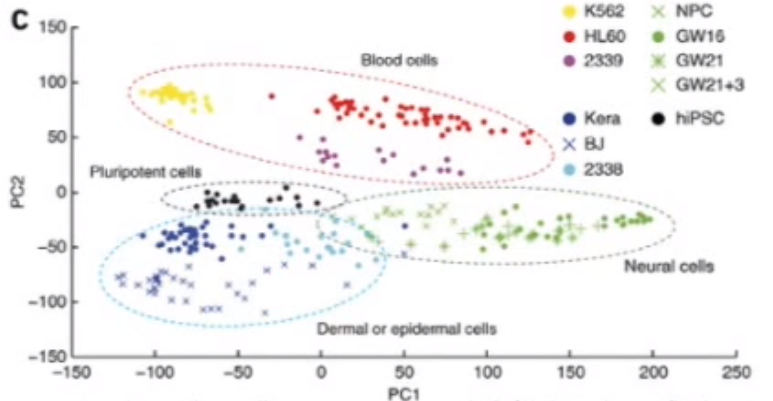

In [6]:
Image('images/pca_yt_6.png')

Second, if we wanted to determine what makes "Neural Cells" fundamentally different from "Blood Cells" we could take a look at the "Influence on PC2" variable to identify the Genes that drive these cells to be clustered in different areas of the reduced space.

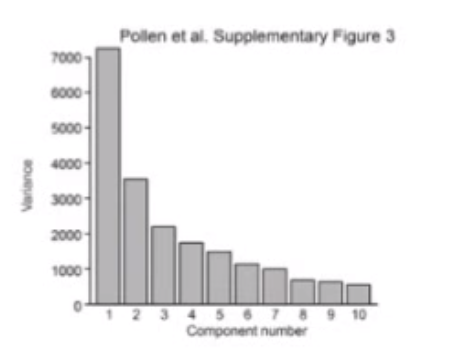

In [7]:
Image('images/pca_yt_7.png')

Third, we can plot explained variance as a function of the number of Principal Components. This helps us identify when to stop reducing the dimensionality of our data.

### Mechanics with Fake Data

So what does that mean in practice?

Following along with [the dataset from Chapter 10](https://github.com/joelgrus/data-science-from-scratch/blob/871bb335ede8b1a104317fdf74e7a5cd485c184c/code/working_with_data.py#L215-L315) of Joel Grus' *Data Science from Scratch*, we've got a dataset that looks like the following.

In [8]:
%pylab inline

import pickle

with open('data/pca_grus.pkl', 'rb') as f:
    X = pickle.load(f)

Populating the interactive namespace from numpy and matplotlib


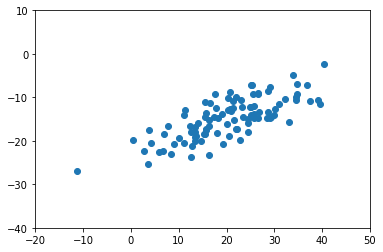

In [9]:
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:, 1])
ax.set_xlim([-20, 50])
ax.set_ylim([-40, 10]);

Again, most of the variation doesn't seem to correspond with either the `x` or `y` axis alone.

### Normalization

Normalize your data such that each attribute has mean zero. Joel doesn't normalize using standard deviation. Though I've seen others use it. Setting to `False` for consistency's sake.

In [10]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler(with_std=False).fit_transform(X)

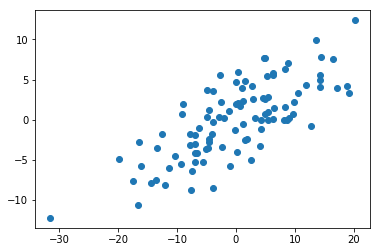

In [11]:
plt.scatter(X[:, 0], X[:, 1]);

### Finding direction that maximizes variance

As above, we want to find some straight line to draw through our data in a path that explains the most variance.

In essence, that means generating a ton of hypothetical lines from the origin, and picking the one that explains the most variance over our data.

So first, a helper function that we can use to rescale any vector `w` to have unit length.

```python
def direction(w):
    """Given a vector w, rescale it to have unit length.
    The result will be an n-dimensional vector from the origin."""
    return np.norm(w)
```

Then, we'll develop measures for explained variance (what we're optimizing over)

``` python 
def directional_variance_i(x_i, w):
    """The dot product of a vector and a direction, squared tells
    us how much variance a hypothetical axis gives us"""
    dir_w = direction(w)
    return np.dot(x_i, w) ** 2

def directional_variance(X, w):
    """Same as above, but the sum across all records in the data"""
    return sum(directional_variance_i(x_i, w)
               for x_i in X) 
```

Because this is an optimization, we'll also need a gradient function

```python
def directional_variance_gradient(X, w):
    """Implementation not important. Just calculus."""
    return deriv_of_variance_fn(X, w)
```

Finally, Joel pipes these into a gradient descent function

``` python
def first_principal_component(X):
    guess = [1 for _ in X[0]]                             # init to 1
    unscaled_maximizer = maximize_batch(                  # custom max fn he cooked up
        cost_fn = directional_variance(X),                # see above
        cost_gradient = directional_variance_gradient(X), # see above
        guess)                                            # updated on each step of maximize_batch
    return direction(unscaled_maximizer)                  # normalized to unit length. Just a direction
```

His result (we'll trust him) returns `[0.924, 0.383]`, which looks about right.

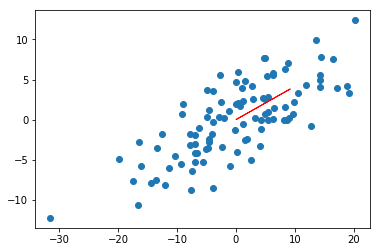

In [12]:
vec_x = 0.924
vec_y = 0.383

# scaling the `dx` and `dy` args so the line shows up better
scaling = 10

plt.scatter(X[:, 0], X[:, 1]);
plt.arrow(x=0, y=0,
          dx=vec_x*scaling,
          dy=vec_y*scaling,
          color='red')

### Project

Now we can project our data down onto the first Principal Component using a dot product.

In [13]:
import numpy as np

In [14]:
def project_one_vector(v, w):
    w = np.array(w)
    projection_length = np.dot(v, w)
    return projection_length * w

In [15]:
def project_matrix(X, w):
    proj = np.array([project_one_vector(x_i, w)
                     for x_i in X])
    return proj

Of course, projecting from 2D to 1D just means a straight line, lol

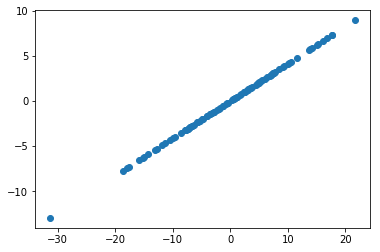

In [16]:
w = [0.924, 0.383]
proj_X = project_matrix(X, w)

plt.scatter(proj_X[:, 0], proj_X[:, 1]);

### More Principal Components

On the flip side, if we had a higher-order dataset and wanted to find more Principal Components, we would *subtract* the projection from each vector, and re-run the same search for a principal component.

In [17]:
def remove_projection_one_vector(v, w):
    return v - project_one_vector(v, w)

def remove_projection_matrix(X, w):
    return np.array([remove_projection_one_vector(x_i, w)
                     for x_i in X])

Here's the same data, transformed to remove our first component.

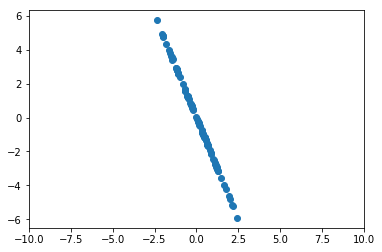

In [18]:
x_sans_proj = remove_projection_matrix(X, w)
plt.scatter(x_sans_proj[:, 0], x_sans_proj[:, 1])
plt.xlim(-10, 10);

Re-running `first_principal_component` on this data would yield another Principal Component. At scale, we can iteratively gather and more components with the following:

``` python
def PCA(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection_matrix(component)
        
    return components
```

Then after running this, we can transform our original dataset to it's lower-dimension representation with

``` python
def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform_matrix(X, components):
    return [transform_vector(x_i, components) for x_i in X]
```

## On a Real Dataset w sklearn

Of course, after you've got the concepts down, reaching for a neater implementation is usually a good idea.

We'll be using Paulo Corez's [Forest Fires dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names) to examine this concept.

This dataset is:

- Some X/Y coordinates representing location of the fire in the park
- Month and Day columns of the fire
- A bunch of numeric columns representing various metrics relevant to this study
- A final `area` column outlining how much area the fire wound up spreading to.

In [19]:
import requests
from io import StringIO

import pandas as pd

In [20]:
conn = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

df = pd.read_csv(StringIO(conn.text))

For purposes of demonstration, the specifics of the variables is of little importance to us, as we'll be reducing them anyhow. Of course in practice, the resulting components should be human-interpretable.

In [21]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


We'll omit the categorical variables.

In [22]:
df_num = df.select_dtypes(['int64', 'float64'])

Scaling our data as before, we can see that we've got 0 means.

In [23]:
df_num = StandardScaler().fit_transform(df_num.values)
df_num.mean(axis=0)

array([ 2.11307438e-16,  2.61127891e-16, -1.75230559e-15, -2.74871465e-17,
        6.87178661e-17,  1.03076799e-17,  2.54256105e-16,  2.19897172e-16,
       -4.19178983e-16, -6.87178661e-18,  4.12307197e-17])

This time, we'll import a simple `PCA` object from `sklearn.decomposition`

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_num)

Investigating the `explained_variance_ratio_` property, we see that by about the 6th Principal Component, we can explain 90% of the variance.

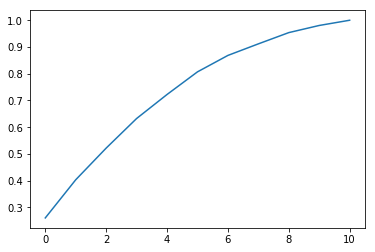

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

And so we'll re-fit accordingly.

In [26]:
ideal_pca = PCA(n_components=6)
df_num_6pcs = ideal_pca.fit_transform(df_num)

In [27]:
df_num.shape

(517, 11)

In [28]:
ideal_pca.components_.shape

(6, 11)

In [29]:
df_num_6pcs.shape

(517, 6)